In [4]:
!pip install facenet-pytorch

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("frabbisw/facial-age")

print("Path to dataset files:", path)

100%|██████████| 840M/840M [00:11<00:00, 75.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/frabbisw/facial-age/versions/1


In [6]:
import shutil
import os

source_path = path
destination_path = "/content/facial-age"

# Move the dataset
shutil.move(source_path, destination_path)

print("Dataset moved to:", destination_path)
print("Files in new location:", os.listdir(destination_path))

Error: Destination path '/content/facial-age/1' already exists

In [7]:


import os
import re
import numpy as np
import pandas as pd
import torch
from PIL import Image
import cv2
from facenet_pytorch import MTCNN
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.manifold import TSNE

In [8]:

base_path = '/content/facial-age/face_age/'
image_folders = os.listdir(base_path)

# print(image_folders)

age_labels = []
gender_labels = []
image_paths = []
image_names = []

for dir_name in image_folders:
    dir_path = os.path.join(base_path, dir_name)
    image_files = os.listdir(dir_path)
    for img in image_files:
        try:
            age = int(dir_name)
            age_labels.append(age)
            image_names.append(img)
            image_paths.append(os.path.join(base_path,dir_name,img))
        except Exception as e:
            # the dataset folder has another folder with the dataset itself: This will prevent that folder from joining the df
            continue


df = pd.DataFrame({
    'image_path': image_paths,
    'image_name': image_names,
    'age': age_labels
})

df

,image_path,image_name,age
0,/content/facial-age/face_age/010/1995.png,1995.png,10
1,/content/facial-age/face_age/010/8039.png,8039.png,10
2,/content/facial-age/face_age/010/8881.png,8881.png,10
3,/content/facial-age/face_age/010/2847.png,2847.png,10
4,/content/facial-age/face_age/010/8569.png,8569.png,10
...,...,...,...
9773,/content/facial-age/face_age/067/4235.png,4235.png,67
9774,/content/facial-age/face_age/067/9179.png,9179.png,67
9775,/content/facial-age/face_age/067/1636.png,1636.png,67
9776,/content/facial-age/face_age/067/9700.png,9700.png,67


In [9]:
df['Age_Group'] = pd.qcut(df['age'], q=4, labels=range(0,4))
df['Age_Interval'] = pd.qcut(df['age'], q=4)

df

,image_path,image_name,age,Age_Group,Age_Interval
0,/content/facial-age/face_age/010/1995.png,1995.png,10,1,"(7.0, 25.0]"
1,/content/facial-age/face_age/010/8039.png,8039.png,10,1,"(7.0, 25.0]"
2,/content/facial-age/face_age/010/8881.png,8881.png,10,1,"(7.0, 25.0]"
3,/content/facial-age/face_age/010/2847.png,2847.png,10,1,"(7.0, 25.0]"
4,/content/facial-age/face_age/010/8569.png,8569.png,10,1,"(7.0, 25.0]"
...,...,...,...,...,...
9773,/content/facial-age/face_age/067/4235.png,4235.png,67,3,"(49.0, 110.0]"
9774,/content/facial-age/face_age/067/9179.png,9179.png,67,3,"(49.0, 110.0]"
9775,/content/facial-age/face_age/067/1636.png,1636.png,67,3,"(49.0, 110.0]"
9776,/content/facial-age/face_age/067/9700.png,9700.png,67,3,"(49.0, 110.0]"


In [10]:
df['Age_Interval'].unique()

[(7.0, 25.0], (49.0, 110.0], (0.999, 7.0], (25.0, 49.0]]
Categories (4, interval[float64, right]): [(0.999, 7.0] < (7.0, 25.0] < (25.0, 49.0] <
                                           (49.0, 110.0]]

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
mtcnn = MTCNN(image_size=224, select_largest=True, keep_all=True, device=device)

In [13]:
transform_pipeline = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3, interpolation=3, fill=0),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [14]:
from sklearn.model_selection import train_test_split

class facialAge(Dataset):
    def __init__(self, df, transform=None, preprocess=None):
        self.df = df
        self.transform = transform
        self.preprocess = preprocess

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        img_path = os.path.join(img_path)
        label = self.df.iloc[idx]['Age_Group']  # Age group label for classification

        image = Image.open(img_path)
        if self.preprocess:
            image = self.preprocess(image)
        if self.transform:
            image = self.transform(image)

        return image, label



train_df, test_df = train_test_split(df, test_size=0.2, random_state=21)

train_dataset = facialAge(train_df, transform_pipeline)
test_dataset = facialAge(test_df, transform_pipeline)

train_df

,image_path,image_name,age,Age_Group,Age_Interval
6508,/content/facial-age/face_age/048/4603.png,4603.png,48,2,"(25.0, 49.0]"
5595,/content/facial-age/face_age/063/8434.png,8434.png,63,3,"(49.0, 110.0]"
6565,/content/facial-age/face_age/058/2094.png,2094.png,58,3,"(49.0, 110.0]"
279,/content/facial-age/face_age/065/6587.png,6587.png,65,3,"(49.0, 110.0]"
4218,/content/facial-age/face_age/009/8774.png,8774.png,9,1,"(7.0, 25.0]"
...,...,...,...,...,...
9336,/content/facial-age/face_age/016/8444.png,8444.png,16,1,"(7.0, 25.0]"
48,/content/facial-age/face_age/010/3342.png,3342.png,10,1,"(7.0, 25.0]"
8964,/content/facial-age/face_age/026/6417.png,6417.png,26,2,"(25.0, 49.0]"
5944,/content/facial-age/face_age/013/8363.png,8363.png,13,1,"(7.0, 25.0]"


In [15]:
num_classes = 4

In [16]:
model = models.efficientnet_b0(pretrained=True)

num_ftrs = model.classifier[-1].in_features


model.classifier[-1] = nn.Linear(num_ftrs, num_classes)


feature_extractor = torch.nn.Sequential(*(list(model.children())[:-1]))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 22.5MB/s]


In [17]:
model = model.to(device)

In [18]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
num_epochs = 10
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

for epoch in range(num_epochs):

    model.train()

    running_loss = 0.0

    correct_train = 0
    total_train = 0

    for batch in dataloader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item() * images.size(0)  # Total loss across all samples

        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()

        total_train += labels.size(0)

    avg_train_loss = running_loss / len(dataloader.dataset)  # Average loss per sample
    train_accuracy = 100 * correct_train / total_train

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

print("Training complete.")

Epoch [1/10], Training Loss: 0.6661, Training Accuracy: 71.71%
Epoch [2/10], Training Loss: 0.5061, Training Accuracy: 78.50%
Epoch [3/10], Training Loss: 0.4409, Training Accuracy: 81.94%
Epoch [4/10], Training Loss: 0.4197, Training Accuracy: 82.69%
Epoch [5/10], Training Loss: 0.3813, Training Accuracy: 83.83%
Epoch [6/10], Training Loss: 0.3688, Training Accuracy: 84.97%
Epoch [7/10], Training Loss: 0.3447, Training Accuracy: 86.04%
Epoch [8/10], Training Loss: 0.3311, Training Accuracy: 86.64%
Epoch [9/10], Training Loss: 0.3077, Training Accuracy: 87.22%
Epoch [10/10], Training Loss: 0.2932, Training Accuracy: 88.02%
Training complete.


In [20]:
model.eval()

correct_test = 0
total_test = 0

all_predictions = []
all_labels = []

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs, 1)

        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Calculate and print the final test accuracy
test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

conf_matrix = confusion_matrix(all_labels, all_predictions)

precision, recall, f1_score, support = precision_recall_fscore_support(all_labels, all_predictions)

print("Confusion Matrix:\n", conf_matrix)
print("\nPrecision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1_score)
print("Samples per class:", support)

Test Accuracy: 81.34%
Confusion Matrix:
 [[490  36   2   0]
 [ 33 415  39   3]
 [  2 120 285  47]
 [  1   9  73 401]]

Precision per class: [0.93155894 0.71551724 0.71428571 0.88913525]
Recall per class: [0.9280303  0.84693878 0.6277533  0.8285124 ]
F1-score per class: [0.92979127 0.77570093 0.66822978 0.85775401]
Samples per class: [528 490 454 484]


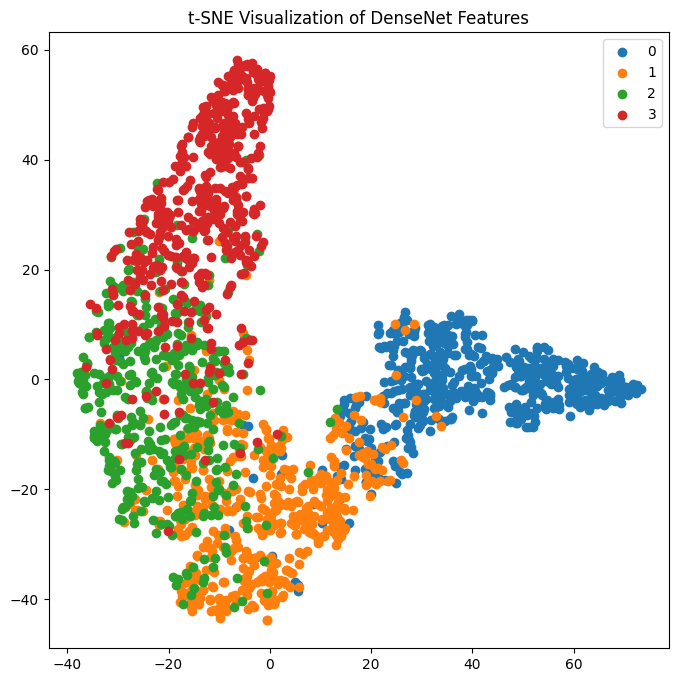

In [21]:
features = []
labels = []
with torch.no_grad():
    for images, label in test_loader:
        images = images.to(device)
        outputs = feature_extractor(images)
        features.append(outputs.view(outputs.size(0), -1).cpu())
        labels.append(label.cpu())

features = torch.cat(features, dim=0).numpy()
labels = torch.cat(labels, dim=0).numpy()

tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features)

plt.figure(figsize=(8, 8))
for label in set(labels):
    plt.scatter(
        reduced_features[labels == label, 0],
        reduced_features[labels == label, 1],
        label=str(label)
    )
plt.legend()
plt.title("t-SNE Visualization of DenseNet Features")
plt.show()